# Tutorial 1 : Thermomechanical Model

# A quick Lithospheric Model with visco-plastic non-linear rheologies

version 0.2
Romain Beucher
romain.beucher@unimelb.edu.au

The following tutorial presents a simple usage of the geodynamics module.
The *geodynamics* module intents to facilitate rapid prototyping of geodynamics models. It can be seen as a set of high-level functions within the underworld ecosystem. It is a means to quickly get the user into Underworld modelling and assumes very little knowledge in coding. The module make some assumptions based on how the user defines the boundary conditions and the properties of the materials (rocks, phases). 

Its simplicity comes with a relatively more rigid workflow (compared to the classic Underworld functions).
However, the user can easily break the high level objects and get back to core Underworld function at any step of model design. As we think the low-level interface is more flexible, and in so allows for more complex models, we strongly encourage users to explore and break the High Level functions. We hope that the user will naturally move to the low-level functionalities as he or her gets more confident, and by doing so will access the wide range of possibilities offered by Underworld.

The module can be imported as follows:

In [63]:
import UWGeodynamics as GEO

# Working with units

Note that this is not an obligation and you can use values without units 


The geodynamics module enables usage of a broad range of units using a *UnitRegistry*. You can attach a unit to any value that you need to define. A value with a units attached becomes a *Quantity* python object. The geodynamics module take care of the conversion internally so you may use any units that you think are appropriate. You can also mix them.

The module will also try to work out a scaling of the values to help the computation process. The user can chose to alter the way his or her values are scaled or can rely on the default options.

To use the units system, you can link the unit registry as follow:

In [64]:
u = GEO.UnitRegistry

## Scaling

In [65]:
half_rate = 1.8 * u.centimeter / u.year
model_length = 360e3 * u.meter
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

# Define the external geometry

The first step is to define the geometry of our problem, essentially a box on which we will apply some physical constraints and that will contain a set of materials. We can think of it as an "universe".
The "laws" and their effects are calculated on a mesh, that mesh discretized our universe into finite elements.

The geodynamics module allows you to quickly set up a model by creating a *Model* object.
A series of arguments are required to define a *Model*:

    - The number of elements in each direction elementRes=(nx, ny);
    - The minimum coordinates for each axis minCoord=(minX, minY)
    - The maximum coordinates for each axis maxCoord=(maxX, maxY)
    - A vector that defines the magnitude and direction of the gravity components gravity=(gx, gy)
 

In [66]:
Model = GEO.Model(elementRes=(180, 60), 
                  minCoord=(0. * u.kilometer, -110. * u.kilometer), 
                  maxCoord=(360. * u.kilometer, 10. * u.kilometer), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

In [67]:
Model.outputDir="outputs"

# Add some Materials

Now that we have our "universe" (box, sand pit) ready, we need to fill it with some materials.
The *geodynamics* module is designed around that idea of materials, which are essentially a way to define physical properties across the Model domain.

A material (or a phase) is first defined by the space it takes in the box (its shape).

In [68]:
Model.diffusivity = 1e-6 * u.metre**2 / u.second 
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

The Model we are building is essentially a layered cake. The geodynamics module provide and easy way to define a layer by defining shape as *layer* and specifying its *top* and *bottom*. The order is important: when 2 shapes overlay each other, only the second is used.

In [69]:
# Air Layer
air = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=0 * u.kilometer))
air.density = 1. * u.kilogram / u.metre**3
air.radiogenicHeatProd = 0.0
air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)

In [70]:
air

In [71]:
# Uppercrust Layer
uppercrust = Model.add_material(name="Upper Crust", shape=GEO.shapes.Layer(top=0. * u.kilometer, bottom=-20. * u.kilometer))
uppercrust.radiogenicHeatProd = 0.7 * u.microwatt / u.meter**3
uppercrust.density  = GEO.LinearDensity(reference_density=2600. * u.kilogram / u.metre**3)

In [72]:
uppercrust

In [73]:
# Midcrust Layer
midcrust = Model.add_material(name="Mid Crust", shape=GEO.shapes.Layer(top=-20. * u.kilometer, bottom=-25. * u.kilometer))
midcrust.radiogenicHeatProd = 0.6 * u.microwatt / u.meter**3
midcrust.density = GEO.LinearDensity(reference_density=2900. * u.kilogram / u.metre**3)

In [74]:
# Lower Crust Layer
lowercrust = Model.add_material(name="Lower Crust",shape=GEO.shapes.Layer(top=-25. * u.kilometer, bottom=-60. * u.kilometer))
lowercrust.radiogenicHeatProd = 0.4 * u.microwatt / u.meter**3
lowercrust.density  = GEO.LinearDensity(reference_density=2900. * u.kilogram / u.metre**3)

In [75]:
# Sediment
sediment = Model.add_material(name="Sediment")
sediment.radiogenicHeatProd = 0.6 * u.microwatt / u.meter**3
sediment.density = GEO.LinearDensity(reference_density=2300. * u.kilogram / u.metre**3)

In [76]:
# Heavy Crust Layer
heavycrust = Model.add_material(name="Heavy Crust", shape=GEO.shapes.Layer(top=-35. * u.kilometer, bottom=-40. * u.kilometer))
heavycrust.radiogenicHeatProd = 0.6 * u.microwatt / u.meter**3
heavycrust.density  = GEO.LinearDensity(reference_density=2900. * u.kilogram / u.metre**3)

In [77]:
# Mantle Layer
mantle = Model.add_material(name="Mantle", shape=GEO.shapes.Layer(top=-60. * u.kilometer, bottom=Model.bottom))
mantle.density = GEO.LinearDensity(reference_density=3370. * u.kilogram / u.metre**3)
mantle.radiogenicHeatProd = 0.02e-6 * u.microwatt / u.meter**3

Now we want to define the fault. We can do that by specifying a list of vertices defining the polygon shape.

In [78]:
# Fault
vertices = [(169.  * u.kilometer,  0. * u.kilometer),
            (171. * u.kilometer,   0. * u.kilometer),
            (191. * u.kilometer, -20. * u.kilometer),
            (189. * u.kilometer, -20. * u.kilometer)]

fault = Model.add_material(name="Fault", shape=GEO.shapes.Polygon(vertices))
fault.density = 2620. * u.kilogram / u.metre**3
fault.radiogenicHeatProd = 0.7 * u.microwatt / u.meter**3

We can visualize the material field by calling the *plot_material()* method.


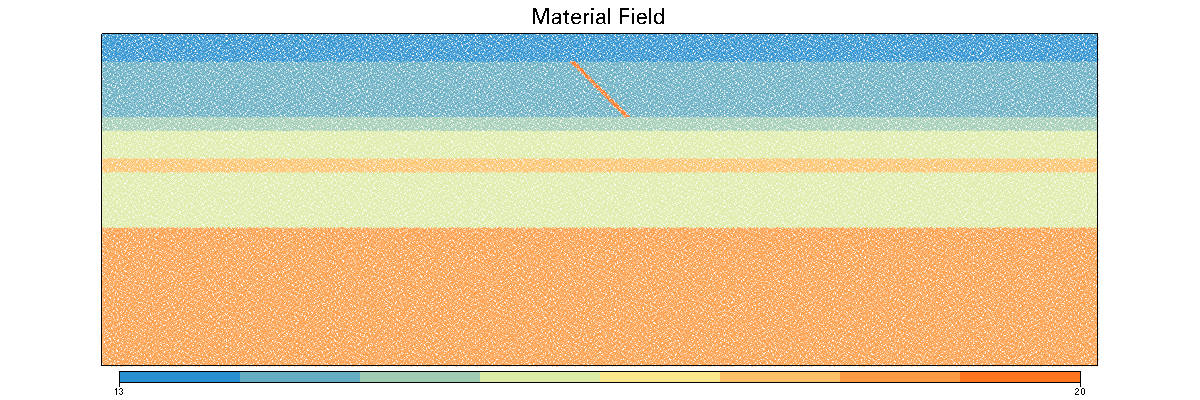

In [79]:
Fig = Model.plot.material(onMesh=False, figsize=(1200,400), fn_size=2.)

In [80]:
import numpy as np

x = np.linspace(Model.minCoord[0], Model.maxCoord[0], 1000) * u.kilometer
y = 0. * u.kilometer

surface_tracers = Model.add_passive_tracers(vertices=[x,y])
moho_tracers = Model.add_passive_tracers(vertices=[x,y-60.*u.kilometer])

x = 100. * u.kilometer
y = np.linspace(Model.minCoord[1], Model.maxCoord[1], 1000) * u.kilometer
vertical_tracers1 = Model.add_passive_tracers(vertices=[x,y])


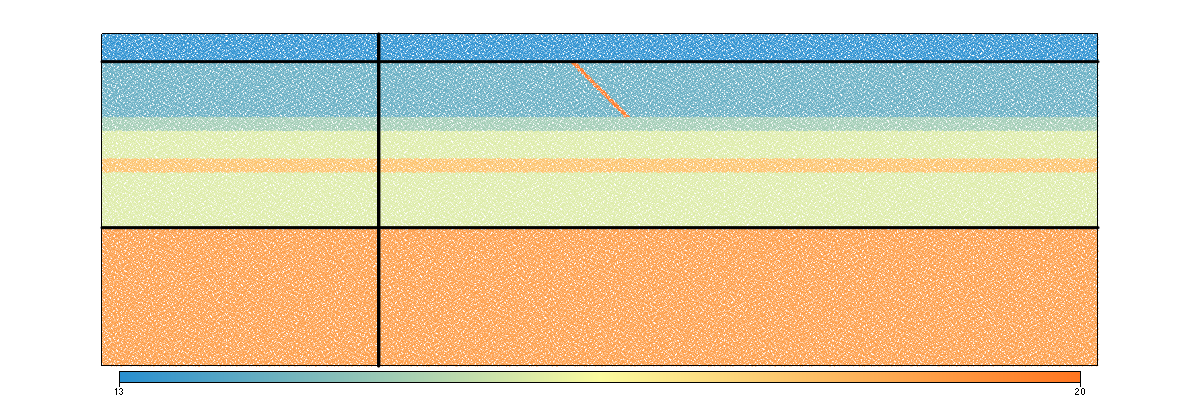

In [81]:
import glucifer
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(surface_tracers.swarm, pointSize=4.0)
Fig.Points(moho_tracers.swarm, pointSize=4.0)
Fig.Points(vertical_tracers1.swarm, pointSize=4.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()

# Define Viscosities

The rheology library contains some commonly used rheologies stored in a python dictionary structure. We can list the keys defining the rheologies as follows:

In [82]:
rh = GEO.ViscousCreepRegistry()

In [83]:
air.viscosity        = 1e19 * u.pascal * u.second
uppercrust.viscosity = rh.Patterson_et_al_1990
sediment.viscosity   = rh.Patterson_et_al_1990
midcrust.viscosity   = rh.Goetze_et_al_1978
lowercrust.viscosity = rh.Wang_et_al_2012
heavycrust.viscosity = rh.Goetze_et_al_1978
mantle.viscosity     = 5e20 * u.pascal * u.second
fault.viscosity      = 1e19 * u.pascal * u.second

In [84]:
sediment

# Define Plasticity

Plastic behavior is assigned using the same approach as for viscosities.

In [85]:
pl = GEO.PlasticityRegistry()

In [86]:
pl.Rey_et_al_2010_LowerCrust

In [87]:
uppercrust.plasticity = pl.Rey_et_al_2010_UpperCrust
sediment.plasticity   = pl.Rey_et_al_2010_UpperCrust
midcrust.plasticity   = pl.Rey_et_al_2010_UpperCrust
lowercrust.plasticity = pl.Rey_et_al_2010_LowerCrust
heavycrust.plasticity = pl.Rey_et_al_2010_LowerCrust
fault.plasticity      = pl.Rey_et_al_2010_Mantle

In [88]:
sediment

## Temperature Boundary Condition

In [89]:
Model.set_temperatureBCs(top=293.15 * u.degK, 
                         bottom=1603.15 * u.degK, 
                         materials=[(air, 293.15 * u.degK )])

## Velocity Boundary Conditions

In [90]:
Model.set_velocityBCs(left=[-1.8 * u.centimeter / u.year, None],
                       right=[1.8 * u.centimeter / u.year, None],
                       bottom=GEO.LecodeIsostasy(reference_mat=mantle.index, average=True))

## Run Model

In [91]:
Model.init_model()


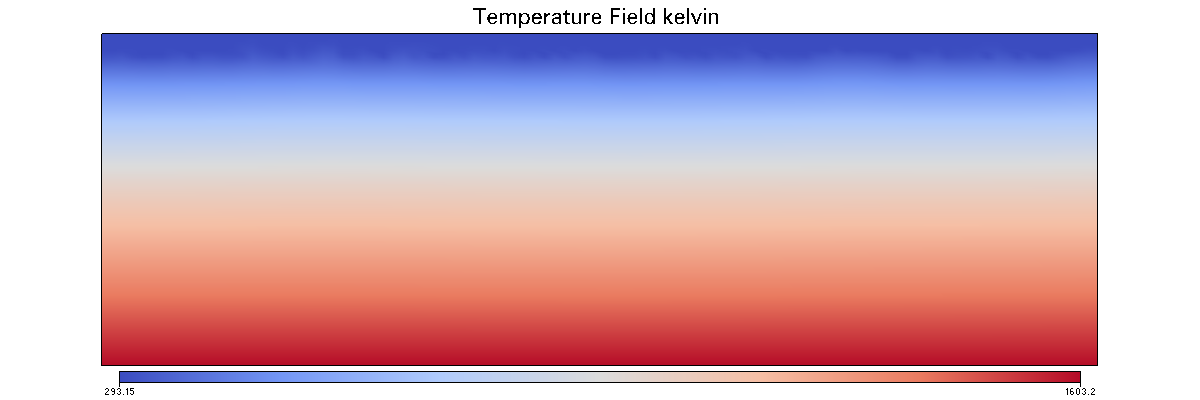

In [92]:
Fig = Model.plot.temperature(figsize=(1200,400))


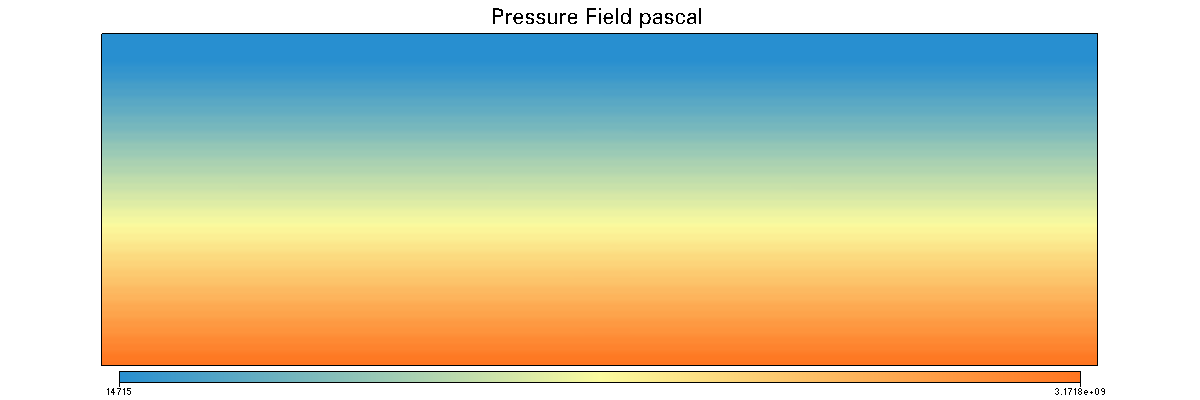

In [93]:
Fig = Model.plot.pressureField(figsize=(1200,400))

# Extract information using passive tracers

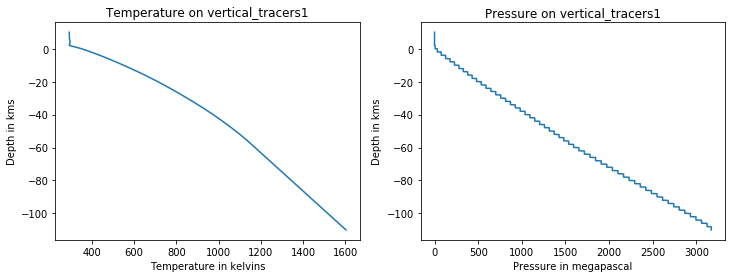

In [94]:
import pylab as plt

depths = vertical_tracers1.swarm.particleCoordinates.data[:,1] * GEO.Dimensionalize(1.0, u.kilometer)

# Extract Temperature
temp = Model.temperature.evaluate(vertical_tracers1.swarm) * GEO.Dimensionalize(1.0, u.degK)

# Extract Pressure
pressure = Model.pressureField.evaluate(vertical_tracers1.swarm) * GEO.Dimensionalize(1.0, u.megapascal) 

Fig, axes = plt.subplots(1,2,figsize=(12,4))
ax1, ax2 = axes
ax1.plot(temp, depths)
ax1.set_xlabel("Temperature in kelvins")
ax1.set_ylabel("Depth in kms")
ax1.set_title("Temperature on vertical_tracers1")

ax2.plot(pressure, depths)
ax2.set_xlabel("Pressure in megapascal")
ax2.set_ylabel("Depth in kms")
ax2.set_title("Pressure on vertical_tracers1")

plt.show()


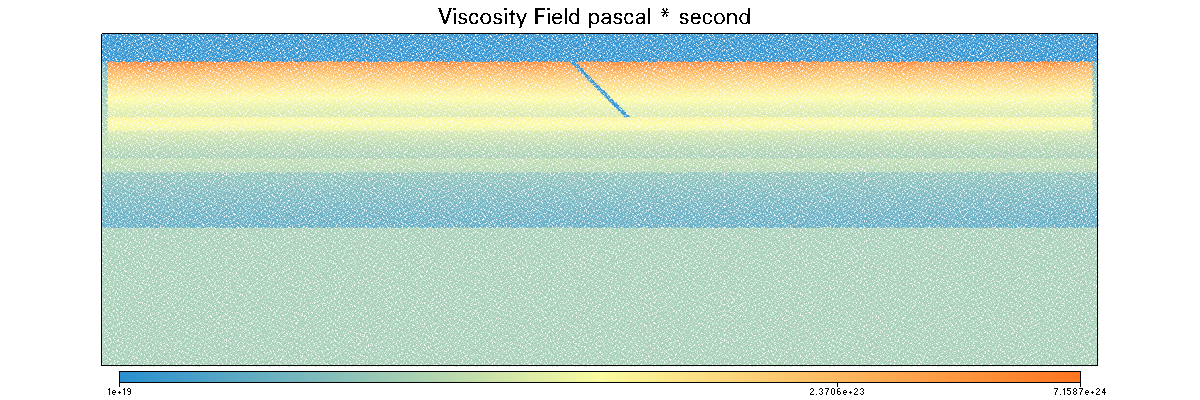

In [95]:
Fig = Model.plot.viscosity(figsize=(1200,400), fn_size=2.)

In [96]:
GEO.rcParams["solver"] = "mumps"
GEO.rcParams["penalty"] = 1e6

In [97]:
Model.run_for(30000.* u.years, checkpoint_interval=10000. * u.years)

Time:  10000.0 year dt: 10000.0 year
Time:  20000.0 year dt: 10000.0 year
Time:  30000.0 year dt: 10000.0 year


1


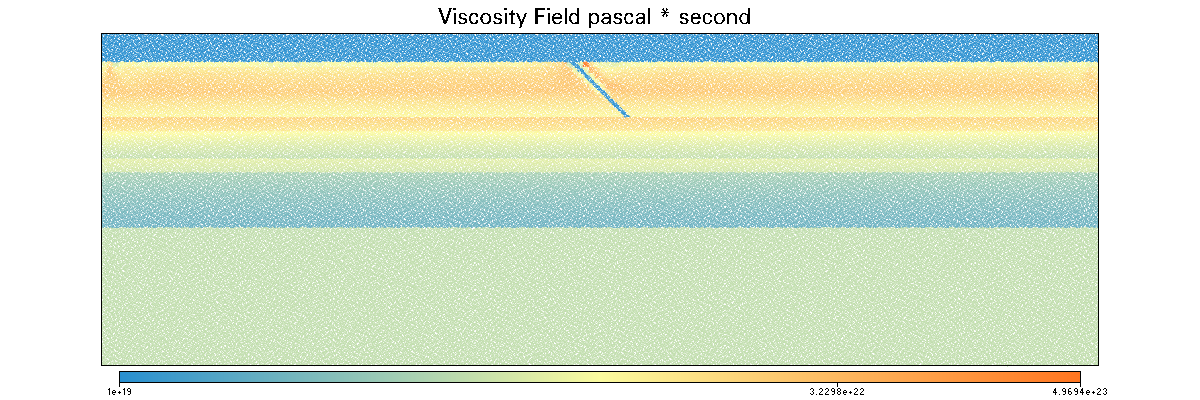

In [98]:
Fig = Model.plot.viscosity(projected=False, figsize=(1200,400), fn_size=2)


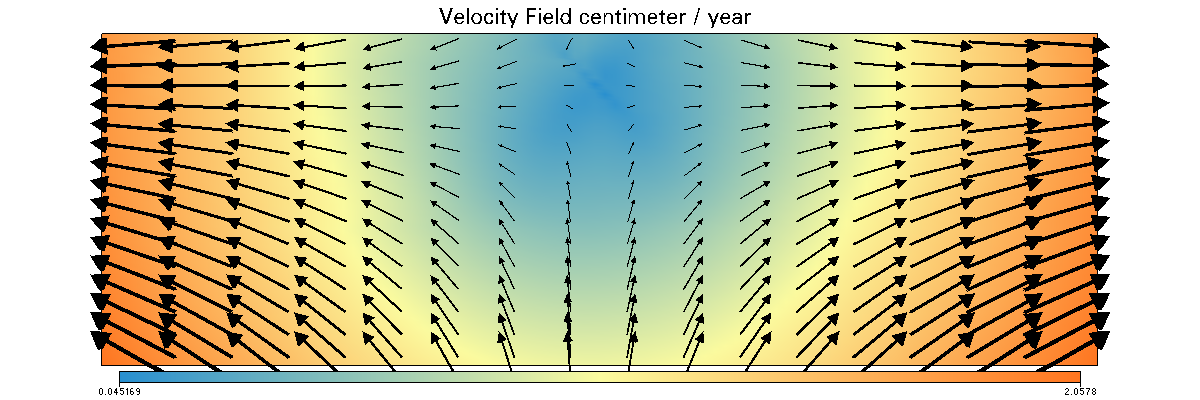

In [99]:
Fig = Model.plot.velocityField(figsize=(1200,400))


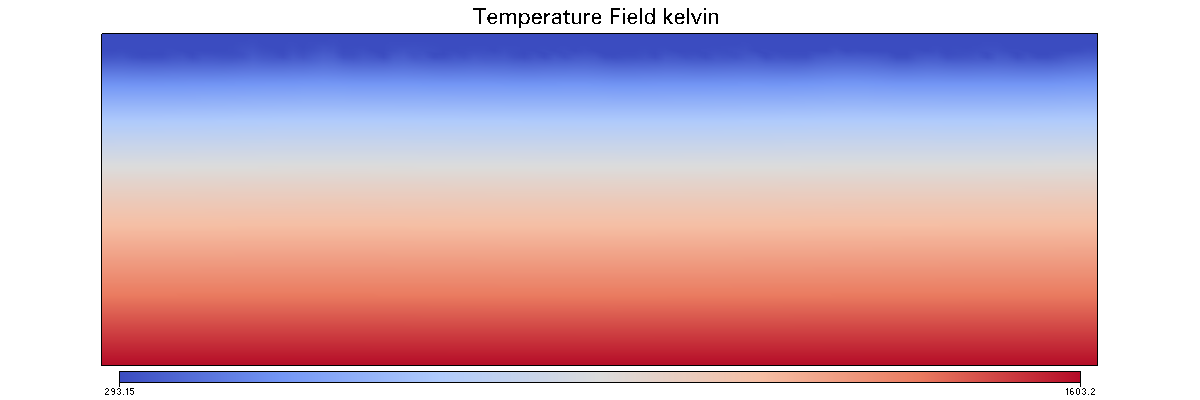

In [100]:
Fig = Model.plot.temperature(figsize=(1200,400))


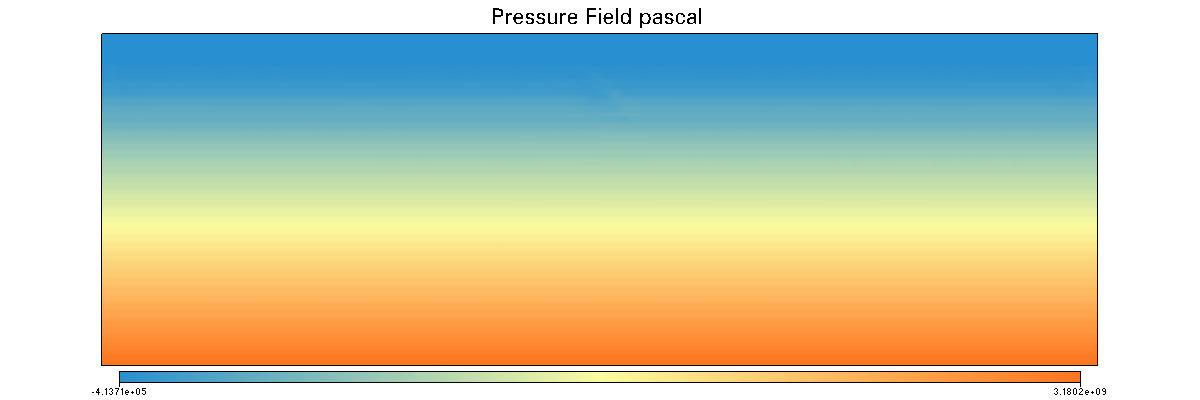

In [101]:
Fig = Model.plot.pressureField(figsize=(1200,400))


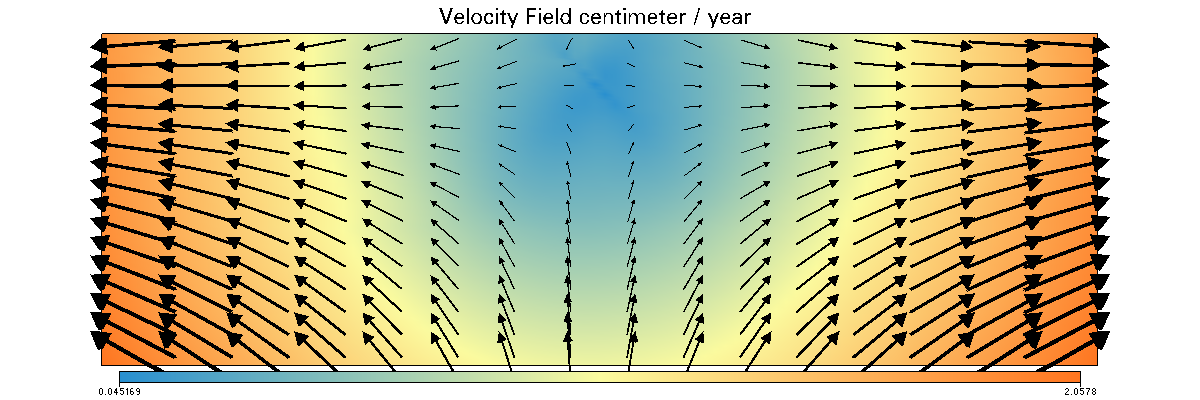

In [102]:
Fig = Model.plot.velocityField(figsize=(1200,400))


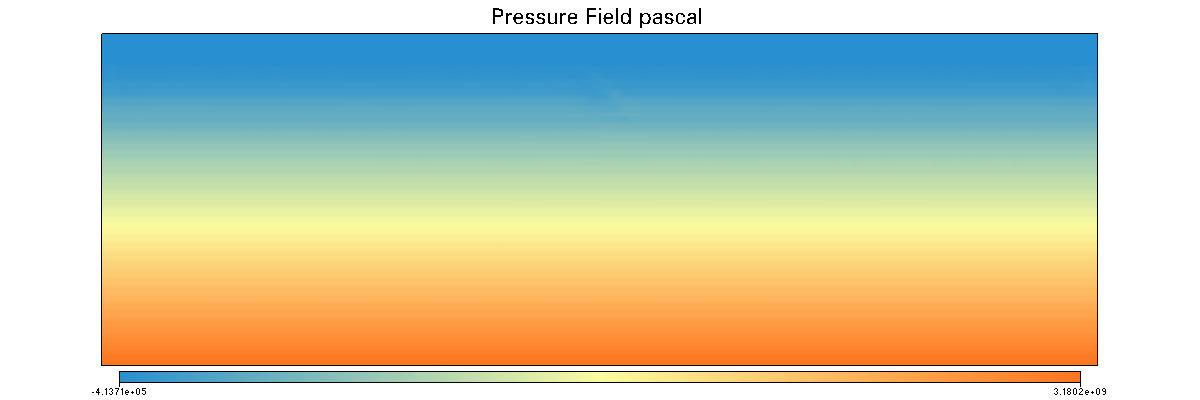

In [103]:
Fig = Model.plot.pressureField(figsize=(1200,400))